# Various tests for pipeline checks

## Import variables


In [39]:
import sys
import os
import io
import logging

from google.cloud import bigquery
from google.cloud import storage

import dask.dataframe as dd
#from dask.distributed import Client
from google.cloud import bigquery
from dask import delayed
import pandas as pd
from sklearn.utils import check_random_state
from scipy.stats import entropy


# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Python packages for data, stats
import numpy as np
import ast
import pandas as pd
import seaborn as sns
import random

# ML
import sklearn
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# To get the time
from datetime import datetime

# To write on the same line
from IPython.display import clear_output

# Set a random seed for reproducibility
random_seed = 42

# Setting the random seed for various libraries
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns




In [4]:
bq_client = bigquery.Client()

In [9]:
PROJECT_ID = "hmh-em-deepasm"
ML_DATASET = "hg19_250_ml"

# Make sure this is the same as in the config file
dic_data = {'TRAINING': {'samples': ['gm12878',
                                  'CD14',
                                  'fibroblast',
                                  'A549',
                                  'spleen_female_adult',
                                  'HeLa_S3']},
            'VALIDATION': {'samples': ['mammary_epithelial',
                                       'sk_n_sh',
                                       'CD34']},
            'TESTING': {'samples': ['HepG2',
                                 'righ_lobe_liver',
                                 't_cell_male_adult']}}

## Functions used in the notebook

In [15]:
def plot_balanced_overlayed_distributions(df, column_names, separator_column='asm_snp'):
    """
    Plots the distribution of specified columns in a DataFrame, overlaying balanced distributions
    based on the separator column values (0 and 1), with distinct colors for each category and only one legend.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    column_names (list of str): The names of the columns to plot.
    separator_column (str): The name of the column used to separate the DataFrame into two groups.

    Returns:
    fig (plotly.graph_objects.Figure): A Plotly Figure object containing the overlayed distribution plots with a single legend.
    """

    opacity_hist = 0.3

    # Separate the DataFrame based on the separator column values
    df_0 = df[df[separator_column] == 0]
    df_1 = df[df[separator_column] == 1]

    # Balance the dataset by sampling
    min_count = min(len(df_0), len(df_1))
    df_0_sampled = df_0.sample(n=min_count, random_state=1)
    df_1_sampled = df_1.sample(n=min_count, random_state=1)

    # Number of columns to plot
    num_columns = len(column_names)

    # Creating subplots: one row for each specified column
    fig = make_subplots(rows=num_columns, cols=1)

    # Adding overlayed histogram subplots for each specified column
    for i, column in enumerate(column_names, start=1):
        fig.add_trace(go.Histogram(x=df_0_sampled[column],
                                   name=f"{separator_column} = 0",
                                   marker_color='blue',
                                   opacity=opacity_hist,
                                   showlegend=(i==1)),
                      row=i, col=1)
        fig.add_trace(go.Histogram(x=df_1_sampled[column],
                                   name=f"{separator_column} = 1",
                                   marker_color='red',
                                   opacity=opacity_hist,
                                   showlegend=(i==1)),
                      row=i, col=1)

        # Update x-axis title
        fig.update_xaxes(title_text=column, row=i, col=1)

    # Update layout for better readability, display, and single legend configuration
    fig.update_layout(height=300*num_columns, title_text="Balanced Overlayed Column Distributions", barmode='overlay', showlegend=True)

    return fig


In [90]:
def plot_cpg_regions_from_df(df, array_col, var_col, N, var_values=(0, 1)):
    """
    Plots 2D arrays from a specified column in a DataFrame, separated into two groups
    based on another variable. Rows are sampled randomly. The plots have customized x-labels
    and y-labels, and the colors are mapped to specific meanings.

    Parameters:
    - df: DataFrame containing the data.
    - array_col: The name of the column with the 2D arrays.
    - var_col: The name of the column to use for separating the data into two groups.
    - N: Number of arrays to plot for each group.
    - var_values: A tuple with the two values of the variable to use for grouping the arrays.
    """
    rows = N  # Assuming 1 plot per array

    # Custom colorscale for the meanings of 0, 1, and 2
    colorscale = [[0, 'lightgrey'], [1/3, 'lightgrey'],  # no CpG
                  [1/3, 'SkyBlue'], [2/3, 'SkyBlue'],  # Unmethylated CpG
                  [2/3, 'Purple'], [1, 'Purple']]  # Methylated CpG


    subplot_titles = []
    for i in range(N):
        for v in var_values:
            subplot_titles.append(f'ASM: {v}')

    # Create subplots with N rows and 2 columns
    fig = make_subplots(rows=rows, cols=2,
                        subplot_titles=subplot_titles,
                        horizontal_spacing=0.10, vertical_spacing=0.07)

    # Function to add traces for each group
    def add_traces(group, col, asm_value):
        for i, arr in enumerate(group.sample(n=N, random_state=42), start=1):
            #arr = np.array(ast.literal_eval(arr_str))
            # Add heatmap
            fig.add_trace(
                go.Heatmap(z=arr.T, colorscale=colorscale, showscale=False),
                row=i, col=col
            )
            # Set x-axis title
            #fig.update_layout(title_text= f'ASM: {asm_value}')
            fig.update_xaxes(title_text="CpG index (sorted by position)", row=i, col=col)
            # Set y-axis title
            fig.update_yaxes(title_text="Read index (sorted by  FM)", row=i, col=col)

    # Process each group
    for idx, val in enumerate(var_values, start=1):
        group = df[df[var_col] == val][array_col]
        add_traces(group, idx, val)

    # Update layout, adjust as needed
    fig.update_layout(height=350*N, width=800)
    fig.show()



## Plot a few regions with and without ASM

In [13]:
dataset_name = 'TRAINING'
query = f"SELECT * FROM {PROJECT_ID}.{ML_DATASET}.{dataset_name}"
df = bq_client.query(query).to_dataframe()

# Convert list of strings
df['cpg_states_array_padding'] = df['cpg_states_array_padding'].apply(lambda x: np.array([ast.literal_eval(item) for item in x]))


In [27]:
# Identify strongest correlations

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('asm_snp')

# Step 2: Calculate correlation of 'asm_snp' with other numerical columns
correlation_series = df[numerical_cols + ['asm_snp']].corr()['asm_snp'].drop('asm_snp')

# Step 3: Sort by absolute correlation values to identify strongest correlations
strongest_correlations = correlation_series.abs().sort_values(ascending=False)

# Display the sorted correlations
print(strongest_correlations[0:20])

transition_from_4_to_4                0.266794
count_state_4                         0.240760
mean_duration_state_4                 0.233188
transition_probability_from_4_to_4    0.185601
cpg_fm_kd_5                           0.182712
                                        ...   
transition_probability_from_1_to_0         NaN
transition_probability_from_1_to_3         NaN
transition_probability_from_2_to_1         NaN
transition_probability_from_2_to_4         NaN
transition_probability_from_4_to_0         NaN
Name: asm_snp, Length: 178, dtype: float64


Text(0.5, 0.98, 'Regions without ASM')

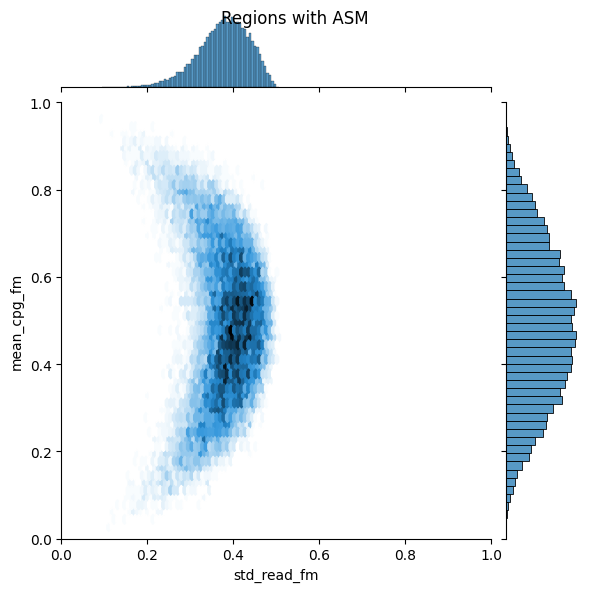

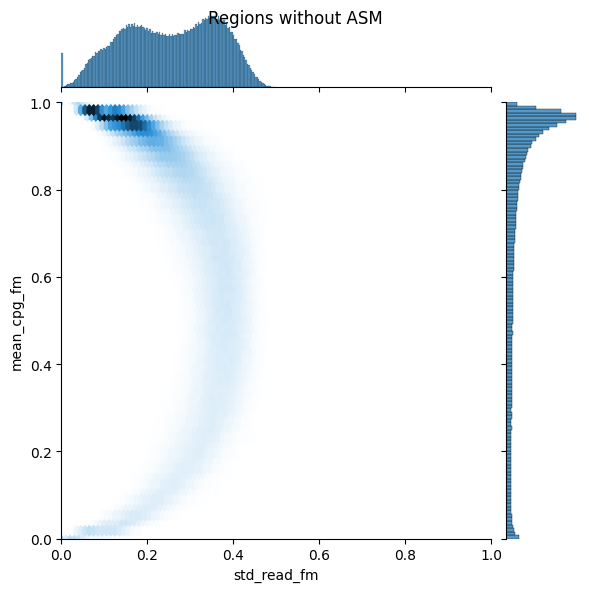

In [33]:
pos_df = df[df['asm_snp'] ==1].copy(deep = True)
neg_df = df[df['asm_snp'] ==0].copy(deep = True)

var_x = 'std_read_fm' # transition_from_4_to_4 std_read_fm
var_y = 'mean_cpg_fm' # mean_cpg_fm

sns.jointplot(x=var_x, y=var_y, data=pos_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions with ASM")

sns.jointplot(x=var_x, y=var_y, data=neg_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions without ASM")

# plt.savefig("with_ASM.png", dpi = 600)
# files.download("with_ASM.png")


In [34]:
plot_balanced_overlayed_distributions(df,
                                       ['nb_reads',
                                       'std_cpg_fm',
                                       'mean_cpg_fm',
                                       'std_read_fm',
                                       'mean_read_fm',
                                        'mean_cpg_fm',
                                        'std_cpg_fm',
                                       'std_cpg_dist',
                                       'mean_cpg_dist',
                                        'transition_from_4_to_4',
                                        'count_state_4',
                                        'mean_duration_state_4',
                                        'transition_probability_from_4_to_4'



                                       ])

In [93]:
plot_cpg_regions_from_df(df, 'cpg_states_array_padding', 'asm_snp', 5)
